In [780]:
cd("C:/Users/User/Documents/GitHub/CausalAI-Course/Labs/Assignment/Assignment_5/data")

## Part 1: Heterogenous treatment effects using causal trees and forests

1.1 Load the data

In [781]:
using CSV
using DataFrames

# Read the CSV file into a DataFrame

data = CSV.read("experimental/experimental_control.csv", DataFrame)


Row,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,1,37,11,1,0,1,1,0.0,0.0,9930.05
2,1,22,9,0,1,0,1,0.0,0.0,3595.89
3,1,30,12,1,0,0,0,0.0,0.0,24909.4
4,1,27,11,1,0,0,1,0.0,0.0,7506.15
5,1,33,8,1,0,0,1,0.0,0.0,289.79
6,1,22,9,1,0,0,1,0.0,0.0,4056.49
7,1,23,12,1,0,0,0,0.0,0.0,0.0
8,1,32,11,1,0,0,1,0.0,0.0,8472.16
9,1,22,16,1,0,0,0,0.0,0.0,2164.02


1.2 Find the ATE

In [782]:
using GLM

lm(@formula(re78 ~ treat), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

re78 ~ 1 + treat

Coefficients:
───────────────────────────────────────────────────────────────────────
               Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
(Intercept)  4554.8      408.046  11.16    <1e-24   3752.85     5356.75
treat        1794.34     632.853   2.84    0.0048    550.574    3038.11
───────────────────────────────────────────────────────────────────────

Participation in the National Supported Work Demonstration Job Training Program increases real earnings by $1 794 on average.

1.3 Heterogenous effects with causal trees

Now we perform Athey and Imbens (2016) methodology to calculate the CATE

In [783]:
describe(data)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,treat,0.41573,0,0.0,1,0,Int64
2,age,25.3708,17,24.0,55,0,Int64
3,educ,10.1955,3,10.0,16,0,Int64
4,black,0.833708,0,1.0,1,0,Int64
5,hisp,0.0876404,0,0.0,1,0,Int64
6,marr,0.168539,0,0.0,1,0,Int64
7,nodegree,0.782022,0,1.0,1,0,Int64
8,re74,2102.27,0.0,0.0,39570.7,0,Float64
9,re75,1377.14,0.0,0.0,25142.2,0,Float64


In [784]:
using MLJ

y, X = unpack(data, ==(:re78), !=(:re78));
coerce!(X, :treat => Multiclass,
           :age => Multiclass,
           :educ => Multiclass,
           :black => Continuous,
           :hisp => Continuous,
           :marr => Continuous,
           :nodegree => Continuous);

In [785]:
MLJ.schema(X)

┌──────────┬────────────────┬─────────────────────────────────┐
│ names    │ scitypes       │ types                           │
├──────────┼────────────────┼─────────────────────────────────┤
│ treat    │ Multiclass{2}  │ CategoricalValue{Int64, UInt32} │
│ age      │ Multiclass{34} │ CategoricalValue{Int64, UInt32} │
│ educ     │ Multiclass{14} │ CategoricalValue{Int64, UInt32} │
│ black    │ Continuous     │ Float64                         │
│ hisp     │ Continuous     │ Float64                         │
│ marr     │ Continuous     │ Float64                         │
│ nodegree │ Continuous     │ Float64                         │
│ re74     │ Continuous     │ Float64                         │
│ re75     │ Continuous     │ Float64                         │
└──────────┴────────────────┴─────────────────────────────────┘


In [786]:
D, X = unpack(X, ==(:treat), !=(:treat));

In [787]:
MLJ.schema(X)

┌──────────┬────────────────┬─────────────────────────────────┐
│ names    │ scitypes       │ types                           │
├──────────┼────────────────┼─────────────────────────────────┤
│ age      │ Multiclass{34} │ CategoricalValue{Int64, UInt32} │
│ educ     │ Multiclass{14} │ CategoricalValue{Int64, UInt32} │
│ black    │ Continuous     │ Float64                         │
│ hisp     │ Continuous     │ Float64                         │
│ marr     │ Continuous     │ Float64                         │
│ nodegree │ Continuous     │ Float64                         │
│ re74     │ Continuous     │ Float64                         │
│ re75     │ Continuous     │ Float64                         │
└──────────┴────────────────┴─────────────────────────────────┘


In [788]:
onehotencoder = @load OneHotEncoder pkg=MLJModels verbosity=0

ohe = onehotencoder(features = [:age, :educ])
ohe_machine = machine(ohe, X)
fit!(ohe_machine);
X = MLJ.transform(ohe_machine, X);

┌ Info: Training machine(OneHotEncoder(features = [:age, :educ], …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Spawning 34 sub-features to one-hot encode feature :age.
└ @ MLJModels C:\Users\User\.julia\packages\MLJModels\ziReN\src\builtins\Transformers.jl:878
┌ Info: Spawning 14 sub-features to one-hot encode feature :educ.
└ @ MLJModels C:\Users\User\.julia\packages\MLJModels\ziReN\src\builtins\Transformers.jl:878


In [789]:
MLJ.schema(X)

┌─────────┬────────────┬─────────┐
│ names   │ scitypes   │ types   │
├─────────┼────────────┼─────────┤
│ age__17 │ Continuous │ Float64 │
│ age__18 │ Continuous │ Float64 │
│ age__19 │ Continuous │ Float64 │
│ age__20 │ Continuous │ Float64 │
│ age__21 │ Continuous │ Float64 │
│ age__22 │ Continuous │ Float64 │
│ age__23 │ Continuous │ Float64 │
│ age__24 │ Continuous │ Float64 │
│ age__25 │ Continuous │ Float64 │
│ age__26 │ Continuous │ Float64 │
│ age__27 │ Continuous │ Float64 │
│ age__28 │ Continuous │ Float64 │
│ age__29 │ Continuous │ Float64 │
│ age__30 │ Continuous │ Float64 │
│ age__31 │ Continuous │ Float64 │
│ age__32 │ Continuous │ Float64 │
│    ⋮    │     ⋮      │    ⋮    │
└─────────┴────────────┴─────────┘
                   38 rows omitted


In [790]:
LogisticClassifier = @load LogisticClassifier pkg=MLJScikitLearnInterface

log_model = LogisticClassifier()

log_model_machine = machine(log_model,X, D)

fit!(log_model_machine)

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\User\.julia\packages\MLJModels\ziReN\src\loading.jl:159


import MLJScikitLearnInterface ✔


┌ Info: Training machine(LogisticClassifier(penalty = l2, …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
C:\Users\User\.julia\environments\v1.10\.CondaPkg\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\User\.julia\environments\v1.10\.CondaPkg\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

trained Machine; caches model-specific representations of data
  model: LogisticClassifier(penalty = l2, …)
  args: 
    1:	Source @911 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @695 ⏎ AbstractVector{Multiclass{2}}


In [791]:
pscore = pdf.(MLJ.predict(log_model_machine, X),1)

445-element Vector{Float64}:
 0.4851438552412901
 0.2711953954581939
 0.4810007529521278
 0.5342528499223365
 0.5173143648688432
 0.435682558817189
 0.5273269672250014
 0.3422319161666199
 0.5452745133608601
 0.5203563437447176
 ⋮
 0.39260630726830825
 0.46138433296949916
 0.1896844324795016
 0.5499742027646627
 0.42294420830889484
 0.32979348683114507
 0.47195931816044356
 0.610601542777451
 0.4100659255149634

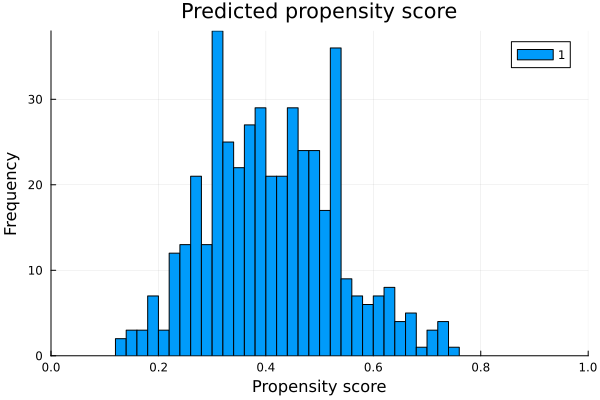

In [792]:
using Plots

histogram(pscore, bins=30, title="Predicted propensity score", label = "1",
         xlabel="Propensity score", ylabel="Frequency",xlims=(0, 1))

In [793]:
y_star = data.re78 ./ (data.treat .* pscore .- (1 .- data.treat) .* (1 .- pscore))

445-element Vector{Float64}:
  20468.25037802182
  13259.421447378796
  51786.71564622092
  14049.80057136786
    560.1814025560271
   9310.663955649581
      0.0
  24755.605199020138
   3968.683515607689
  23864.550633002757
      ⋮
     -0.0
     -0.0
  -8755.749249128823
 -27463.557969876336
     -0.0
     -0.0
 -32005.679415407438
 -18859.76621368656
  -9236.287607231961

In [794]:
mean(y_star)

1800.1182261179688

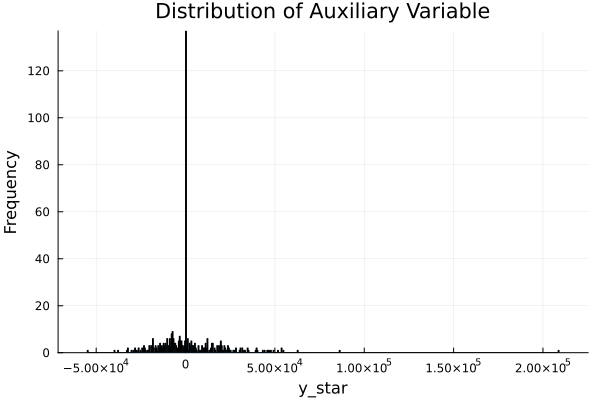

In [795]:
histogram(y_star, bins=1000, title="Distribution of Auxiliary Variable", label = false,
         xlabel="y_star", ylabel="Frequency")     

In [796]:
X = select!(X, Not(:age__17, :educ__3));

In [797]:
DecisionTreeRegressor = (@load DecisionTreeRegressor pkg=DecisionTree verbosity=0)
tree_model = DecisionTreeRegressor(max_depth = 2)
tree_machine = machine(tree_model, X, y_star)
fit!(tree_machine);

┌ Info: Training machine(DecisionTreeRegressor(max_depth = 2, …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499


In [798]:
fitted_params(tree_machine)[1]

educ__14 < 0.5
├─ re74 < 2653.0
│  ├─ 2332.3001011374163 (0/355)
│  └─ -1676.8440228178372 (0/83)
└─ 16037.73265894198 (0/7)


The interpretation is subject to the depth your tree ends up with. As specified in the issue, we would stick to what we saw in class (that is, an arbitrarily small tree). However, do not forget that a proper way to tune hyperparameters is Cross-Validation.

1.4 Heterogenous effects with causal forests

In [799]:
RandomForestRegressor = @load RandomForestRegressor pkg=DecisionTree verbosity = 0
forest_model = RandomForestRegressor(n_trees = 200)
forest_machine = machine(forest_model, X, y_star)
fit!(forest_machine)

┌ Info: Training machine(RandomForestRegressor(max_depth = -1, …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499


trained Machine; caches model-specific representations of data
  model: RandomForestRegressor(max_depth = -1, …)
  args: 
    1:	Source @953 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @780 ⏎ AbstractVector{Continuous}


In [800]:
feature_importances(forest_machine)

52-element Vector{Pair{Symbol, Float64}}:
     :re75 => 0.23092319743956416
     :re74 => 0.13909139442941673
  :age__28 => 0.06161911266388581
    :black => 0.043849895196276995
     :marr => 0.04245831385780032
 :educ__11 => 0.04147719842027286
  :age__31 => 0.031513561027236625
 :educ__10 => 0.028861781432864553
  :educ__9 => 0.026629064127491765
     :hisp => 0.021524368253491993
           ⋮
  :educ__4 => 0.0013381013303493893
  :age__39 => 0.0009478119056802549
  :age__54 => 0.0009360764316434807
  :age__55 => 0.0007749244903485293
  :age__41 => 0.0007427916971503385
  :age__48 => 0.0007296061753063913
  :age__46 => 0.0007215586722120773
 :educ__16 => 0.0004096299979003327
  :age__50 => 0.00027174950879485597

In [801]:
fitted_params(forest_machine)[1]

Ensemble of Decision Trees
Trees:      200
Avg Leaves: 180.43
Avg Depth:  33.43

1.5 Plot heterogenous effects

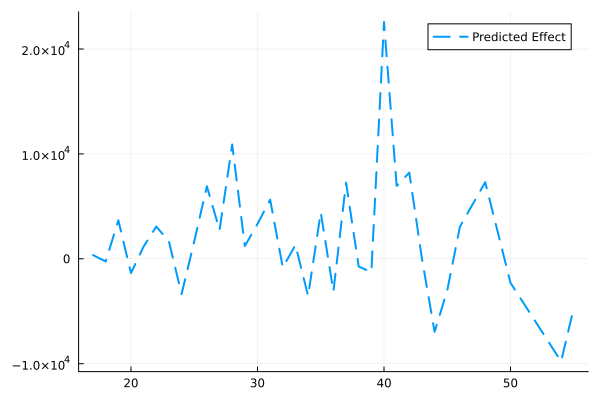

In [802]:
data.predicted_effect = MLJ.predict(forest_machine, X);
predicted_effect_bins = combine(groupby(data, :age), :predicted_effect => mean => :mean_predicted_effect);


plot(predicted_effect_bins.age, predicted_effect_bins.mean_predicted_effect, label="Predicted Effect", lw=2, linestyle=:dash)

## Part 2: Double/Debiased machine learning in obsevational data

2.1 Load the data

In [803]:
data = CSV.read("observational/biased_control.csv", DataFrame)

Row,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78,agesq,agecube,educsq,u74,u75,interaction1,re74sq,re75sq
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,0,45,11,0,0,1,1,21.5167,25.2436,25.5647,2025,91125,121,0,0,236.683,462.967,637.237
2,0,21,14,0,0,0,0,3.17597,5.85256,13.4961,441,9261,196,0,0,44.4636,10.0868,34.2525
3,0,38,12,0,0,1,0,23.039,25.1308,25.5647,1444,54872,144,0,0,276.468,530.796,631.555
4,0,48,6,0,0,1,1,24.9944,25.2436,25.5647,2304,110592,36,0,0,149.966,624.718,637.237
5,0,18,8,0,0,1,1,1.6693,10.7276,9.86087,324,5832,64,0,0,13.3544,2.78655,115.082
6,0,22,11,0,0,1,1,16.3658,18.4493,25.5647,484,10648,121,0,0,180.023,267.838,340.376
7,0,48,10,0,0,1,1,16.8046,16.3546,18.0593,2304,110592,100,0,0,168.046,282.396,267.473
8,0,18,11,0,0,0,1,1.14421,3.62003,15.7393,324,5832,121,0,0,12.5863,1.30922,13.1046
9,0,48,9,0,0,1,1,25.8623,25.2436,25.5647,2304,110592,81,0,0,232.761,668.86,637.237


2.2 Group comparisons

In [804]:
control = data[data.treat .== 0, :];
treated = data[data.treat .== 1, :];

In [805]:
describe(control)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,treat,0.0,0,0.0,0,0,Int64
2,age,33.2252,16,31.0,55,0,Int64
3,educ,12.0275,0,12.0,18,0,Int64
4,black,0.0735368,0,0.0,1,0,Int64
5,hisp,0.072036,0,0.0,1,0,Int64
6,marr,0.711731,0,1.0,1,0,Int64
7,nodegree,0.295835,0,0.0,1,0,Int64
8,re74,14.0168,0.0,15.1236,25.8623,0,Float64
9,re75,13.6508,0.0,14.5571,25.2436,0,Float64


In [806]:
describe(treated)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,treat,1.0,1,1.0,1,0,Int64
2,age,25.8162,17,25.0,48,0,Int64
3,educ,10.3459,4,11.0,16,0,Int64
4,black,0.843243,0,1.0,1,0,Int64
5,hisp,0.0594595,0,0.0,1,0,Int64
6,marr,0.189189,0,0.0,1,0,Int64
7,nodegree,0.708108,0,1.0,1,0,Int64
8,re74,2.09557,0.0,0.0,35.0401,0,Float64
9,re75,1.53206,0.0,0.0,25.1422,0,Float64


The first thing to notice in the observational dataset is that the treated are significantly less than the controls. Among the features, age shows a clear difference of nearly 10 years on average between groups. The same can be said from de real income, with an average difference between groups of around $8 000 dollars. And so on.

As stated in the issue, the treatment and the control groups are not comparable. Therefore, these differences may be significant.

2.3 Compute the SMD

In [807]:
lm(@formula(re78 ~ treat), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

re78 ~ 1 + treat

Coefficients:
─────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  14.8467    0.0761429  194.98    <1e-99   14.6974    14.9959
treat        -8.49752   0.712021   -11.93    <1e-31   -9.89316   -7.10188
─────────────────────────────────────────────────────────────────────────

Unlike the controlled experiment, this result tells us that participation in the National Supported Work Demonstration Job Training Program reduces real earnings by $8 498 on average; this shows the clear bias due to the lack of a proper control group. 

2.4 Using DML

In [808]:
y = data[!,"re78"];

d = data[!,"treat"];
# d= reshape(d, (length(y),1))
x = data[!,Not(["re78", "treat"])];

In [809]:
function training_sample_append(cv_split, test_sample_index)
    training_indices = []
    for vector in cv_split[Not(test_sample_index)]
            training_indices = [training_indices; vector]
    end
    return training_indices, cv_split[test_sample_index]
end

function dml(x, d, y, dreg, yreg, nfold)
    n = length(y)
    cv = [partition(eachindex(y), fill(1/nfold, nfold-1)..., shuffle = true, rng = 1234)...]
    machine_y = machine(yreg, x, y, scitype_check_level=0)
    machine_d = machine(dreg, x, d, scitype_check_level=0)
    y_hat = zeros(n)
    d_hat = zeros(n)

    for fold in 1:nfold
            training_fold, test_fold = training_sample_append(cv, fold)
            y_hat[test_fold] = MLJ.predict(MLJ.fit!(machine_y, rows = training_fold), x[test_fold, :])
            d_hat[test_fold] = MLJ.predict(MLJ.fit!(machine_d, rows = training_fold), x[test_fold, :])
    end

    resy = y .- y_hat
    resd = reshape(d .- d_hat, (n, 1))
    estimate = lm(resd, resy)
    coef_est = GLM.coef(estimate)[1]
    se = GLM.coeftable(estimate).cols[2][1]
    println(" coef (se) = ", coef_est ,"(",se,")")
    return coef_est, se, resy, resd;
end

function summarize(point, stderr, resy, resd, name)
    return DataFrame(
            model = [name],
            estimate = [point], stderr = [stderr], 
            rmse_y = [sqrt(mean(resy .^ 2))], 
            rmse_d = [sqrt(mean(resd .^ 2))]
    )
end

summarize (generic function with 1 method)

In [810]:
LinearRegressor = @load LinearRegressor pkg=MLJScikitLearnInterface verbosity=0
dreg = Standardizer() |> LinearRegressor()
yreg = Standardizer() |> LinearRegressor()
result_ols = dml(x, d, y, dreg, yreg, 10);
table_ols = summarize(result_ols..., "OLS")

LassoCVRegressor = @load LassoCVRegressor pkg=MLJScikitLearnInterface verbosity=0
dreg = Standardizer() |> LassoCVRegressor(max_iter=200000)
yreg = Standardizer() |> LassoCVRegressor(max_iter=200000)
results_lasso = dml(x, d, y, dreg, yreg, 10);
table_lasso = summarize(results_lasso..., "LassoCV")

RandomForestRegressor = @load RandomForestRegressor pkg=MLJScikitLearnInterface verbosity=0
dreg = RandomForestRegressor()
yreg = RandomForestRegressor()
results_rf = dml(x, d, y, dreg, yreg, 10);
table_rf = summarize(results_rf..., "RF");


dreg = RandomForestRegressor()
yreg = Standardizer() |> LinearRegressor()
results_mix = dml(x, d, y, dreg , yreg, 10)
table_mix = summarize(results_mix..., "OLS/RF");

┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:standardizer, …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:linear_regressor, …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:standardizer, …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:linear_regressor, …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase C:\Users\User\.julia\pac

 coef (se) = 1.5709386603561408(0.5566576621515644)


┌ Info: Training machine(:standardizer, …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:linear_regressor, …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:standardizer, …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:lasso_cv_regressor, …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:standardizer, …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machi

 coef (se) = -6.864861434602234(0.6890101388572876)


┌ Info: Training machine(RandomForestRegressor(n_estimators = 100, …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(RandomForestRegressor(n_estimators = 100, …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(RandomForestRegressor(n_estimators = 100, …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(RandomForestRegressor(n_estimators = 100, …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(RandomForestRegressor(n_estimators = 100, …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(RandomForestRegressor(n_estimators = 100, …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(RandomForestRegressor(n_estimators = 100, …), …).
└ @ MLJBase C:\User

 coef (se) = 1.3262057172191233(0.6392773024158233)


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:standardizer, …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:linear_regressor, …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(RandomForestRegressor(n_estimators = 100, …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:standardizer, …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:linear_regressor, …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.

 coef (se) = 0.9475493762316396(0.6053559979263713)


┌ Info: Training machine(RandomForestRegressor(n_estimators = 100, …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499


In [811]:
using PrettyTables
pretty_table([table_ols; table_lasso; table_rf; table_mix])

┌─────────┬──────────┬──────────┬─────────┬───────────┐
│   model │ estimate │   stderr │  rmse_y │    rmse_d │
│  String │  Float64 │  Float64 │ Float64 │   Float64 │
├─────────┼──────────┼──────────┼─────────┼───────────┤
│     OLS │  1.57094 │ 0.556658 │  6.9873 │ 0.0986685 │
│ LassoCV │ -6.86486 │  0.68901 │ 9.30882 │  0.105902 │
│      RF │  1.32621 │ 0.639277 │ 7.40098 │ 0.0910136 │
│  OLS/RF │ 0.947549 │ 0.605356 │  6.9873 │ 0.0907465 │
└─────────┴──────────┴──────────┴─────────┴───────────┘
